# Parameter Inference

Here we infer the parameters of the systems we have observed.

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
import pymc3 as pm
import scipy.stats as ss
import seaborn as sns
import sys
import theano
import theano.tensor as tt
import theano.tensor.extra_ops as te
from tqdm import tqdm_notebook
from true_params import uncert

p = '/Users/wfarr/Research/CBCPopulation/O2Populations/code'
try:
    sys.path.index(p)
except ValueError:
    sys.path.append(p)
    
import vt

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

We will want to impose a prior on $\Theta$ that is about right.  A Gaussian gets pretty close:

In [3]:
mu_t = mean(vt.thetas)
sigma_t = std(vt.thetas)

Surprisingly, this is pretty good:

/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


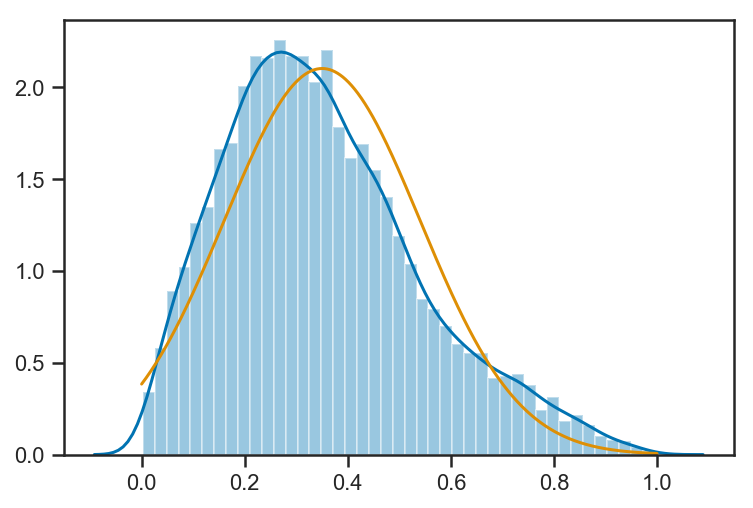

In [4]:
sns.distplot(vt.thetas)
xs = linspace(0, 1, 1000)
plot(xs, ss.norm(loc=mu_t, scale=sigma_t).pdf(xs))

We will need a 2D interpolation function to get the optimal SNR at each mass and distance.

In [37]:
def interp2d(x, y, xs, ys, zs):
    xs = tt.as_tensor_variable(xs)
    ys = tt.as_tensor_variable(ys)
    zs = tt.as_tensor_variable(zs)
    
    i = te.searchsorted(xs, x)
    j = te.searchsorted(ys, y)
    
    i = tt.switch(i < 1, 1, i)
    i = tt.switch(i >= xs.shape[0], xs.shape[0]-1, i)
    
    j = tt.switch(j < 1, 1, j)
    j = tt.switch(j >= ys.shape[0], ys.shape[0]-1, j)
    
    r = (x - xs[i-1])/(xs[i]-xs[i-1])
    s = (y - ys[j-1])/(ys[j]-ys[j-1])

    return (1-r)*(1-s)*zs[i-1,j-1] + r*(1-s)*zs[i,j-1] + (1-r)*s*zs[i-1, j] + r*s*zs[i,j]

Load the optimal SNR observations:

In [6]:
with h5py.File('optimal_snr.h5', 'r') as inp:
    ms = array(inp['ms'])
    osnrs = array(inp['SNR'])

In [38]:
m = pm.Model()

# Placeholders for mc, eta, rho, theta
mco = theano.shared(1.0)
eto = theano.shared(1.0)
ro = theano.shared(1.0)
to = theano.shared(1.0)

sigma_mc = theano.shared(1.0)
sigma_eta = theano.shared(1.0)
sigma_rho = theano.shared(1.0)
sigma_theta = theano.shared(1.0)

with m:
    mcdet = pm.Uniform('mcdet', lower=3, upper=120)
    eta = pm.Uniform('eta', lower=0, upper=0.25)

    disc = eta**(4.0/5.0)*mcdet**2 - 4.0*eta**(9.0/5.0)*mcdet**2
    
    m1det = pm.Deterministic('m1det', (eta**(2.0/5.0)*mcdet + sqrt(disc))/(2*eta))
    m2det = pm.Deterministic('m2det', (eta**(2.0/5.0)*mcdet - sqrt(disc))/(2*eta))
    
    dl = pm.Uniform('dl', lower=0, upper=Planck15.luminosity_distance(2).to(u.Gpc).value)
    theta = pm.Bound(pm.Normal, lower=0, upper=1)('theta', mu=mu_t, sd=sigma_t)
    
    pm.Potential('m1m2-mceta-jac', tt.log(m1det)+tt.log(m2det)-tt.log(m1det-m2det)-(8.0/5.0)*tt.log(eta))
    
    rho_optimal = interp2d(m1det, m2det, ms, ms, osnrs)/dl
    rho_true = rho_optimal*theta
    
    theta_obs = pm.Normal('theta_obs', mu=theta, sd=sigma_theta, observed=to)
    pm.Potential('theta_obs_cum', -tt.log(0.5)-tt.log(tt.erf(theta/(tt.sqrt(2)*sigma_theta)) - tt.erf((theta-1)/(tt.sqrt(2)*sigma_theta))))

    rho_obs = pm.Normal('rho_obs', mu=rho_true, sd=sigma_rho, observed=ro)
    
    eta_obs = pm.Normal('eta_obs', mu=eta, sd=sigma_eta, observed=eto)
    pm.Potential('eta_obs_cum', -tt.log(0.5)-tt.log(tt.erf(eta/(tt.sqrt(2)*sigma_eta)) - tt.erf((eta-0.25)/(tt.sqrt(2)*sigma_eta))))
    
    mc_obs = pm.Lognormal('mc_obs', mu=tt.log(mcdet), sd=sigma_mc, observed=mco)

In [39]:
with h5py.File('observations.h5', 'r') as inp:
    m1s = array(inp['m1s'])
    m2s = array(inp['m2s'])
    zs = array(inp['zs'])
    thetas = array(inp['thetas'])
    
    mcobs = array(inp['mcobs'])
    etaobs = array(inp['etaobs'])
    rhoobs = array(inp['rhoobs'])
    thetaobs = array(inp['thetaobs'])
    
    smcs = array(inp['sigma_mc'])
    sets = array(inp['sigma_eta'])
    srhs = array(inp['sigma_rho'])
    sths = array(inp['sigma_t'])

In [40]:
ifit = random.randint(len(mcobs))
print('Fitting event {:d}'.format(ifit))

Fitting event 1931


In [41]:
n_start = 25
n_tune = 1000
n_draw = 1000
n_jobs = 4

n_window = [n_start]
while np.sum(n_window) < n_tune:
    n_window.append(2*n_window[-1])

mco.set_value(mcobs[ifit])
eto.set_value(etaobs[ifit])
ro.set_value(rhoobs[ifit])
to.set_value(thetaobs[ifit])

sigma_mc.set_value(smcs[ifit])
sigma_eta.set_value(sets[ifit])
sigma_rho.set_value(srhs[ifit])
sigma_theta.set_value(sths[ifit])

with m:
    factor = 1
    while True:
        trace = pm.sample(draws=n_draw*factor, tune=n_draw*factor, njobs=1, chains=n_jobs)

        nef = pm.effective_n(trace)
        ne_min = min([nef[k] for k in ['m1det', 'm2det', 'dl', 'theta']])

        if ne_min > 1000:
            break
        else:
            factor *= 2

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [theta, dl, eta, mcdet]
100%|██████████| 2000/2000 [00:05<00:00, 393.20it/s]
The acceptance probability does not match the target. It is 0.8821709558616072, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8936764731844878, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [theta, dl, eta, mcdet]
100%|██████████| 4000/4000 [00:10<00:00, 369.13it/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `targ

In [42]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mcdet,18.264109,0.281223,0.004508,17.739760,18.838664,3670.124579,1.000135
eta,0.228916,0.015022,0.000278,0.202143,0.250000,2836.519950,1.000495
m1det,28.148403,3.767154,0.080864,21.235761,34.753837,2177.883752,1.000656
m2det,16.184542,2.010406,0.048800,12.787826,20.204099,1645.989535,1.000651
dl,0.987358,0.343422,0.007638,0.341817,1.659487,2267.712252,1.000927
theta,0.309126,0.100704,0.002266,0.116678,0.504777,2191.777627,1.000973


In [43]:
pm.effective_n(trace)

{'dl': 2267.712252156709,
 'eta': 2836.5199497914514,
 'm1det': 2177.883752300245,
 'm2det': 1645.9895349832746,
 'mcdet': 3670.1245790711832,
 'theta': 2191.7776265563}

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1d25ad50>,
      dtype=object)

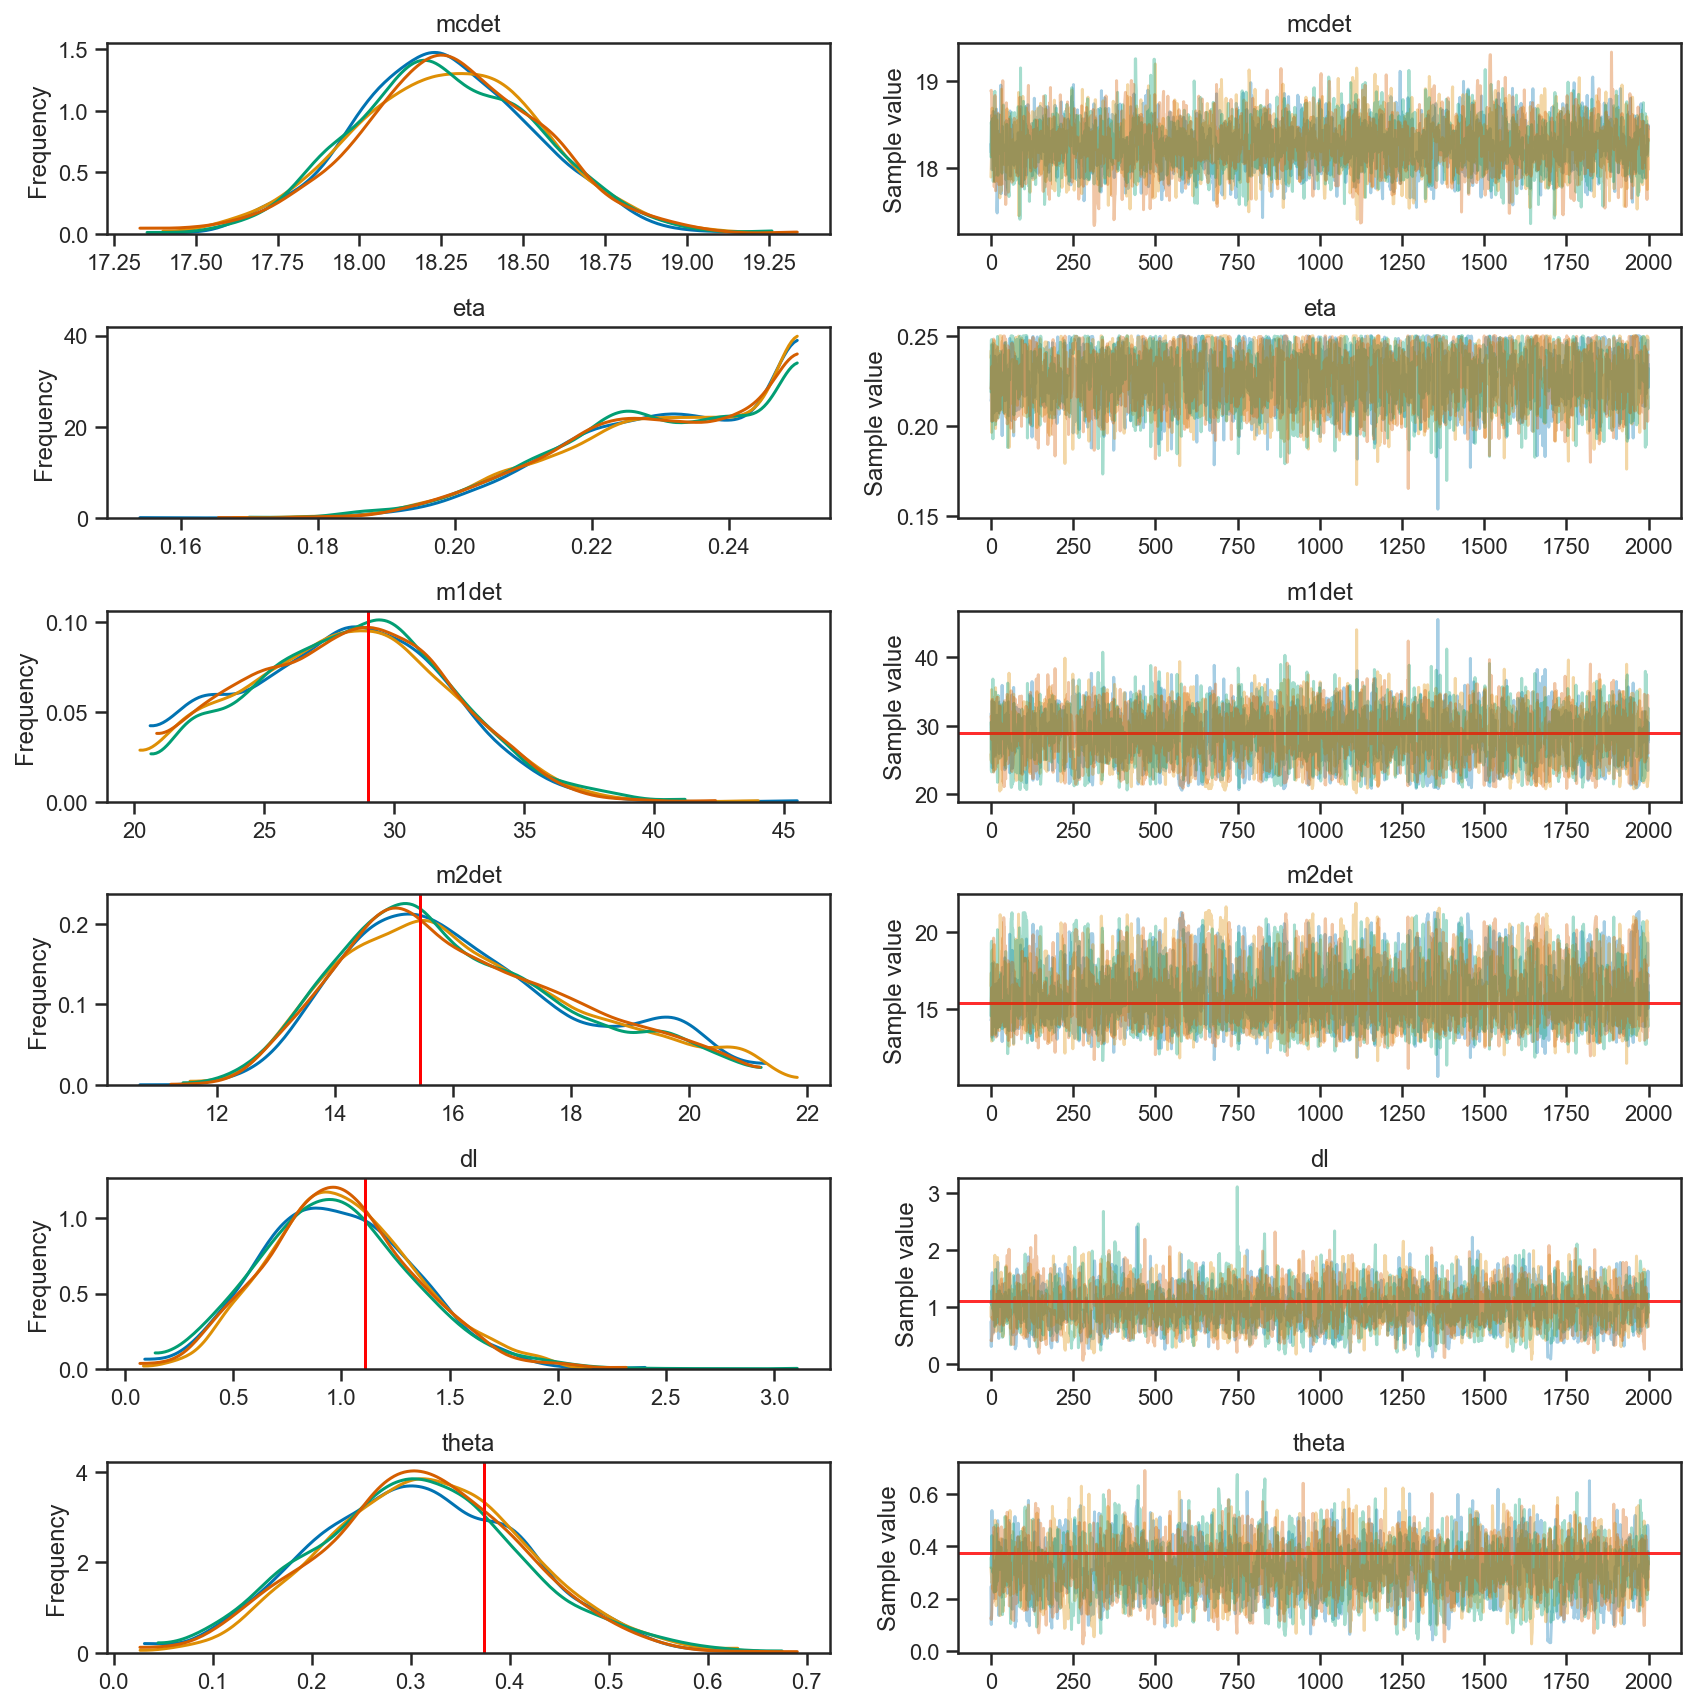

In [44]:
pm.traceplot(trace, lines={'m1det':m1s[ifit]*(1+zs[ifit]), 'm2det':m2s[ifit]*(1+zs[ifit]), 'dl':Planck15.luminosity_distance(zs[ifit]).to(u.Gpc).value, 'theta':thetas[ifit]})

Check out `infer.py` for the full inference.